# Predict Loan's Ever Delinquent Probability
#### Code updated on 11/9/17

In [1]:
get_ipython().magic(u'matplotlib inline')

In [2]:
import pandas as pd
import numpy as np

from scipy import stats, integrate

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from IPython.core import display as ICD

In [3]:
def read_loan(path, filename):
    df = pd.read_csv(path + "\\" + filename, sep='\t', header=0)
    df.columns = col_names
    '''
    Args: 
        path: Location of the import file
        filename: Name of the import file
    Returns:
        df: Imported loan level details data frame
    '''
    return df

def agg_column(df, col_name):
    '''
    Args: 
        df: Data frame the aggregation calculation is based on 
        col_name: Name of aggregated column
    Returns:
        agg_series: The return is a data series. All calcuated values <=1
    '''
    agg_series = df.groupby(col_name).loan_id.nunique() / df.loan_id.nunique()
    return agg_series

def percent_format(float_series, rename_col_index):
    '''
    Args: 
        float_series: Data series with float value
        rename_col_index: The index of column which needs 
                          to be renamed for clarification
    Returns:
        percent_df: The return is a data frame with float formated as %
    '''
    percent = float_series.mul(100).round(1).astype(str) + '%'
    percent_df = pd.DataFrame(percent).reset_index()
    percent_df.rename(columns={percent_df.columns[rename_col_index]: "percent" }, inplace=True)
    #percent_df.rename(columns = {'loan_id':'percent'}, inplace=True)  # Alt: rename a column by name
    return percent_df

# Create histogram method
def histogram(df, title_name):
    '''
    Args: 
        df: Data frame or data series for plotting histogram on feature value distribution 
        title_name: Name of histogram
    Returns:
        Histogram plot using matplotlib
    '''
    return df.plot(kind='bar', title=title_name).set(xlabel='\n' + title_name, ylabel='% to Total')

# Alternative way to create histogram method using feature as parameter
def histogram_alt(feature):
    df = distr_dict[feature]
    title_name = feature.split('_', 1)[0].upper()
    return df.plot(kind='bar', title=title_name).set(xlabel=title_name, ylabel='% to Total')

In [4]:
# rename columns if needed
col_names = ['loan_id','ory','orig_upb','loan_purp','prop_type',
             'multi_unit','orig_chn','occ_stat','dti_new',
             'FICO_new', 'ltv_new', 'fhb_flag', 'no_bor', 
             'prop_type_eligible', 'MI_chl', 'dr_time_default',
             'Ever_Delinquent', 'current_status', 'claim_flag']

features = ['ory', 'loan_purp', 'prop_type', 'multi_unit', 'orig_chn', 
            'occ_stat', 'dti_new', 'FICO_new', 'ltv_new', 'fhb_flag',
            'no_bor', 'prop_type_eligible', 'MI_chl', 'Ever_Delinquent',
            'claim_flag']

#filepath = "C:\\Users\\SunLix\\Data\\Project\\Default Classification"
#filename = "Loan_Orig_2010_2013.txt"

filepath = "C:\\Users\\wliu\\Desktop"
filename = "population list.txt"

# I. Exploratory Data Analysis (EDA)

In [5]:
df = read_loan(filepath, filename)

In [6]:
df.head()

,loan_id,ory,orig_upb,loan_purp,prop_type,multi_unit,orig_chn,occ_stat,dti_new,FICO_new,ltv_new,fhb_flag,no_bor,prop_type_eligible,MI_chl,dr_time_default,Ever_Delinquent,current_status,claim_flag
0,8092146,2010,142200,P,SF,0,R,O,22.5,800,90,Y,2,1,Non-Delegated,NaN,0,17.Cancel,0
1,8092147,2010,160550,P,SF,0,R,O,32.5,730,95,Y,1,1,Non-Delegated,NaN,0,17.Cancel,0
2,8092148,2010,224639,P,SF,0,R,O,27.5,800,97,Y,2,1,Non-Delegated,NaN,0,01.Current,0
3,8092150,2010,340425,P,SF,0,R,O,22.5,730,90,Y,2,1,Non-Delegated,NaN,0,17.Cancel,0
4,8092152,2010,270750,P,SF,0,R,O,32.5,730,95,Y,2,1,Non-Delegated,NaN,0,17.Cancel,0


In [7]:
# Get size of data
df.shape

(481218, 19)

In [8]:
# unique number of loans
df.loan_id.nunique()

481218

In [9]:
# Get the list of columns along with dtypes
df.dtypes

loan_id                 int64
ory                     int64
orig_upb                int64
loan_purp              object
prop_type              object
multi_unit              int64
orig_chn               object
occ_stat               object
dti_new               float64
FICO_new                int64
ltv_new                 int64
fhb_flag               object
no_bor                  int64
prop_type_eligible      int64
MI_chl                 object
dr_time_default       float64
Ever_Delinquent         int64
current_status         object
claim_flag              int64
dtype: object

In [10]:
#check any column with NAN value
df.isnull().any()

loan_id               False
ory                   False
orig_upb              False
loan_purp             False
prop_type             False
multi_unit            False
orig_chn              False
occ_stat              False
dti_new               False
FICO_new              False
ltv_new               False
fhb_flag              False
no_bor                False
prop_type_eligible    False
MI_chl                False
dr_time_default        True
Ever_Delinquent       False
current_status        False
claim_flag            False
dtype: bool

### Features and Target used for Modeling
- **Loan Origination Year**
- **Loan Purpose**: Purchase(P), Refinance with Cash-Out(C), Refinance Pay-off Existing Lien(N)
- **Property Type**: Single-Family and PUD(SF), Condo and Co-Op(CO), Manufactured Housing(MH)
- **Number of Units** 
- **Origination Channel:** Retail(R), Broker(B), Correspondent(C)
- **Occupancy Status:** Prim Resident or Unknown(O), Second(S), Investor(I)
- **DTI**: Debt to Income Ratio
- **FICO**: Borrower combined FICO score
- **LTV**: Loan to property Value Ratio
- **First Time Home Buyer Flag**
- **Number of Borrowers**
- **Property Type Eligible for MI**
- **MI Channel**
- **Ever Delinquenty Flag**
- **Claim Flag**

In [11]:
for feature in features:
    ICD.display(percent_format(agg_column(df, feature), 1))

,ory,percent
0,2010,10.6%
1,2011,15.0%
2,2012,34.5%
3,2013,40.0%


,loan_purp,percent
0,C,2.6%
1,N,32.4%
2,P,65.1%


,prop_type,percent
0,CO,9.8%
1,MH,0.3%
2,SF,89.9%


,multi_unit,percent
0,0,99.9%
1,1,0.1%


,orig_chn,percent
0,R,100.0%


,occ_stat,percent
0,I,0.0%
1,O,96.5%
2,S,3.5%


,dti_new,percent
0,5.0,0.2%
1,12.5,1.2%
2,17.5,4.6%
3,22.5,10.2%
4,27.5,15.5%
5,32.5,18.9%
6,37.5,21.4%
7,42.5,25.3%
8,47.5,2.5%
9,50.0,0.2%


,FICO_new,percent
0,630,0.5%
1,650,1.2%
2,670,2.2%
3,690,6.1%
4,710,8.3%
5,730,13.0%
6,750,17.2%
7,770,20.6%
8,790,20.9%
9,800,9.9%


,ltv_new,percent
0,85,15.6%
1,90,38.7%
2,95,43.5%
3,97,2.3%


,fhb_flag,percent
0,N,68.3%
1,Y,31.7%


,no_bor,percent
0,1,50.8%
1,2,49.2%


,prop_type_eligible,percent
0,0,0.3%
1,1,99.7%


,MI_chl,percent
0,Delegated,66.7%
1,Non-Delegated,33.3%


,Ever_Delinquent,percent
0,0,97.5%
1,1,2.5%


,claim_flag,percent
0,0,99.8%
1,1,0.2%


In [12]:
# Claim Rate by Vintage Year
(df[df['claim_flag']==1]
 .groupby('ory')
 .loan_id.nunique()/df.groupby('ory').loan_id.nunique()
).mul(100).round(1).astype(str) + '%'

ory
2010    0.6%
2011    0.3%
2012    0.1%
2013    0.1%
Name: loan_id, dtype: object

### Distribution on Features Values

In [13]:
# Create dictionary to map feature's distribution
distr_dict = {}
for feature in features:
    distr_series = agg_column(df, feature)
    distr_dict[feature] = distr_series

[<matplotlib.text.Text at 0xa05d128>, <matplotlib.text.Text at 0xa0286a0>]

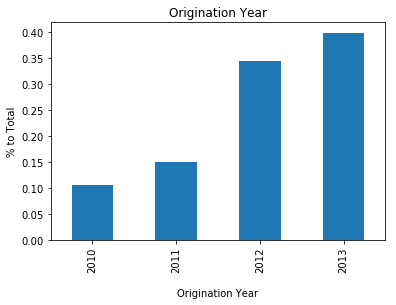

In [14]:
histogram(distr_dict['ory'], 'Origination Year')

[<matplotlib.text.Text at 0xa059780>, <matplotlib.text.Text at 0xa7d7588>]

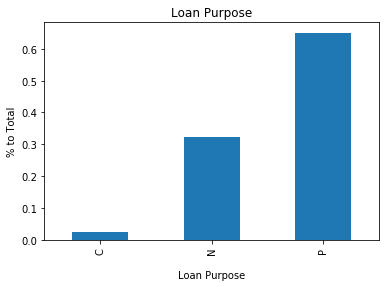

In [15]:
histogram(distr_dict['loan_purp'], 'Loan Purpose')

[<matplotlib.text.Text at 0xa8d5c88>, <matplotlib.text.Text at 0xa8a85c0>]

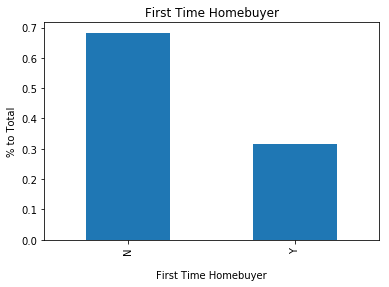

In [16]:
histogram(distr_dict['fhb_flag'], 'First Time Homebuyer')

[<matplotlib.text.Text at 0xa82acc0>, <matplotlib.text.Text at 0xa9374a8>]

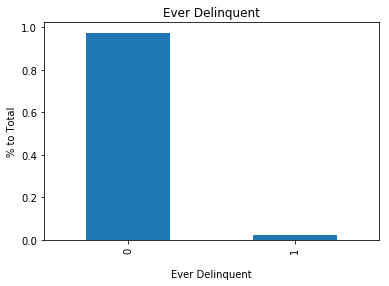

In [17]:
histogram(distr_dict['Ever_Delinquent'], 'Ever Delinquent')

[<matplotlib.text.Text at 0xa8d5748>, <matplotlib.text.Text at 0xa9525f8>]

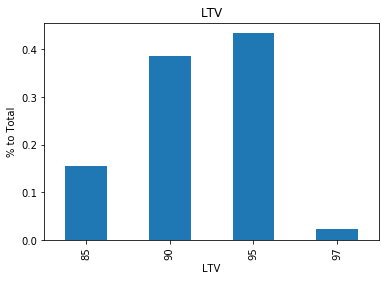

In [18]:
histogram_alt('ltv_new')

[<matplotlib.text.Text at 0xaa9d7b8>, <matplotlib.text.Text at 0xaa87828>]

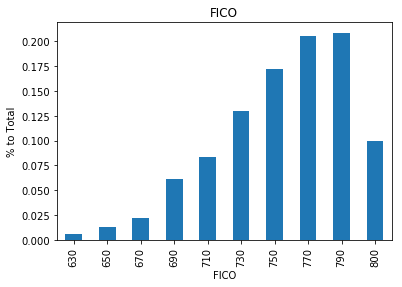

In [19]:
histogram_alt('FICO_new')

[<matplotlib.text.Text at 0xab61a90>, <matplotlib.text.Text at 0xaab82b0>]

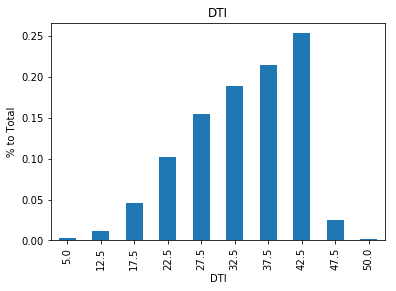

In [20]:
histogram_alt('dti_new')

# II. Modeling

In [21]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

**Due to unbalanced target data, we will need to upsample or downsample one of the class. Here I chose to downsample never delinquent (class 0) loans** 
** >> Select 10,000 per class **

In [22]:
target_col_name = 'Ever_Delinquent'
sample_size = 10000
df_new =df.groupby(target_col_name,as_index=False).apply(lambda x: x.sample(sample_size)).reset_index()

In [23]:
df_new.groupby(target_col_name).loan_id.nunique()

Ever_Delinquent
0    10000
1    10000
Name: loan_id, dtype: int64

### Selected Features to Fit the Model
- **Loan Purpose**: loan_purp 
- **Property Type**: prop_type
- **Occupancy Status**: occ_stat
- **DTI**: dti_new
- **FICO**: FICO_new
- **LTV**: ltv_new
- **First Time Home Buyer Indicator**: fhb_flag
- **MI Channel**: MI_chl
- **Number of Borrower**: no_bor
- **Origination Year**: ory

### Target : Ever Delinquent (Y/N -- 1/0)

In [24]:
# Create a new DataFrame to just include selected features and target
selected_col_name = ['loan_purp', 'prop_type', 'occ_stat', 'dti_new',
                     'FICO_new', 'ltv_new', 'fhb_flag', 'MI_chl',
                     'no_bor','ory','Ever_Delinquent']

df_model = df_new[selected_col_name]

In [25]:
df_model.head()

,loan_purp,prop_type,occ_stat,dti_new,FICO_new,ltv_new,fhb_flag,MI_chl,no_bor,ory,Ever_Delinquent
0,N,SF,O,27.5,690,85,N,Non-Delegated,2,2012,0
1,P,SF,O,42.5,790,90,N,Non-Delegated,1,2012,0
2,N,SF,O,42.5,750,95,N,Delegated,2,2013,0
3,N,SF,O,37.5,690,90,N,Delegated,1,2013,0
4,N,SF,O,27.5,750,95,N,Delegated,2,2012,0


In [26]:
# Split table into "target" vs. "features"
X = df_model.iloc[:,0:-1].values
y = df_model.iloc[:,-1].values

In [27]:
# Encode Categorical Columns to Dummy Variable
feature_ls = ['loan_purp', 'prop_type', 'occ_stat', 'dti_new', 'FICO_new', 
              'ltv_new', 'fhb_flag', 'MI_chl', 'no_bor','ory']
              
df_X = pd.DataFrame(X, columns=feature_ls)

# Create dummy variable and drop one value for each feature
df_X_dummy = pd.get_dummies(df_X, drop_first=True).astype(np.float64)

In [28]:
df_X_dummy.shape

(20000, 32)

In [29]:
df_X_dummy.head()

,loan_purp_N,loan_purp_P,prop_type_MH,prop_type_SF,occ_stat_S,dti_new_12.5,dti_new_17.5,dti_new_22.5,dti_new_27.5,dti_new_32.5,...,FICO_new_800,ltv_new_90,ltv_new_95,ltv_new_97,fhb_flag_Y,MI_chl_Non-Delegated,no_bor_2,ory_2011,ory_2012,ory_2013
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [30]:
# FICO related fields list - used to create model threshold
df_X_FICO = df_X_dummy[['FICO_new_650', 'FICO_new_670', 'FICO_new_690',
                        'FICO_new_710', 'FICO_new_730', 'FICO_new_750',
                        'FICO_new_770', 'FICO_new_790', 'FICO_new_800'
                       ]]

# Change the transformed dataframe to array
X = df_X_dummy.as_matrix()
X_FICO = df_X_FICO.as_matrix()

In [31]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_FICO_train, X_FICO_test, y_FICO_train, y_FICO_test = train_test_split(X_FICO, y, test_size = 0.2, random_state = 0)

### Threshold Creation - Based on FICO Only Prediction

In [32]:
clf_thresh = LogisticRegression()
clf_thresh.fit(X_FICO_train, y_FICO_train)
y_FICO_pred = clf_thresh.predict(X_FICO_test)
print('ROC AUC Score Threshold is %s' % (roc_auc_score(y_FICO_test, y_FICO_pred)))

ROC AUC Score Threshold is 0.65337663039


### Fitting - Applying Different Classifiers on Training Set

In [33]:
# prepare models
models = []
models.append(('LR', LogisticRegression(random_state=0)))
models.append(('LDA', LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)))
models.append(('CART', DecisionTreeClassifier(criterion='entropy', random_state=0)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel="linear", random_state=0)))
models.append(('SVMKernel', SVC(kernel="poly", random_state=0)))
models.append(('RF', RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)))

LR: 0.744760 (0.012631)
LDA: 0.736719 (0.013177)
KNN: 0.658715 (0.013613)
CART: 0.621853 (0.011793)
NB: 0.700488 (0.014715)
SVM: 0.730283 (0.013550)
SVMKernel: 0.718058 (0.013510)
RF: 0.667313 (0.010522)


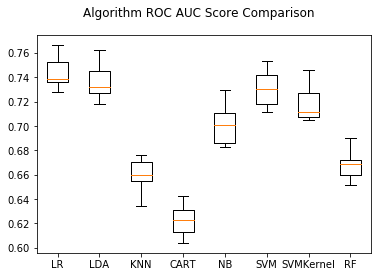

In [34]:
# prepare configuration for cross validation test harness
seed = 7

# Compare AUC score among different models
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm ROC AUC Score Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [35]:
# Find out the probablity of loan in claim with the ever deliquent status
(df[df['claim_flag'] == 1]
  .groupby('Ever_Delinquent')
  .loan_id.nunique()/df.groupby('Ever_Delinquent').loan_id.nunique()
).mul(100).round(1).astype(str) + '%'

Ever_Delinquent
0    nan%
1    8.4%
Name: loan_id, dtype: object

### Perform Regularization and Hyperparameter Tuning on Best Performed Model

In [36]:
# Create logistic regression
lr = LogisticRegression(random_state=0)

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 10-fold cross validation
clf = GridSearchCV(lr, hyperparameters, cv=10, verbose=0)

In [37]:
# Fit grid search
best_model = clf.fit(X_train, y_train)

In [38]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 2.78255940221


In [39]:
penalty = best_model.best_estimator_.get_params()['penalty']
c = best_model.best_estimator_.get_params()['C']

# Model Evaluation

In [40]:
# Use the best hyperparameter to finalize the model
clf_final = LogisticRegression(penalty=penalty, C=c, random_state=0)
clf_final.fit(X_train, y_train)

# Predicting the Test set results
y_pred = clf_final.predict(X_test)

In [41]:
clf_final.coef_

array([[-0.5243971 , -0.53795576,  0.1899796 ,  0.12638764,  0.41550965,
         0.41649698,  0.17096906,  0.29899111,  0.35107525,  0.51688347,
         0.75624854,  0.99210571,  1.07531195, -0.16469046, -0.25462722,
        -0.67792806, -1.18033671, -1.54357996, -1.92353705, -2.35250751,
        -2.66013889, -3.00673774, -3.06484303,  0.11770887,  0.37429827,
         0.45756852, -0.04862289,  0.08429143, -0.84973561, -0.42337267,
        -0.72048468, -0.78828488]])

In [42]:
df_X_dummy.columns.values

array(['loan_purp_N', 'loan_purp_P', 'prop_type_MH', 'prop_type_SF',
       'occ_stat_S', 'dti_new_12.5', 'dti_new_17.5', 'dti_new_22.5',
       'dti_new_27.5', 'dti_new_32.5', 'dti_new_37.5', 'dti_new_42.5',
       'dti_new_47.5', 'dti_new_50.0', 'FICO_new_650', 'FICO_new_670',
       'FICO_new_690', 'FICO_new_710', 'FICO_new_730', 'FICO_new_750',
       'FICO_new_770', 'FICO_new_790', 'FICO_new_800', 'ltv_new_90',
       'ltv_new_95', 'ltv_new_97', 'fhb_flag_Y', 'MI_chl_Non-Delegated',
       'no_bor_2', 'ory_2011', 'ory_2012', 'ory_2013'], dtype=object)

In [43]:
d = {"Feature":df_X_dummy.columns.values, "Coefficients":clf_final.coef_[0]}
pd.DataFrame.from_dict(d)

,Coefficients,Feature
0,-0.524397,loan_purp_N
1,-0.537956,loan_purp_P
2,0.189980,prop_type_MH
3,0.126388,prop_type_SF
4,0.415510,occ_stat_S
5,0.416497,dti_new_12.5
6,0.170969,dti_new_17.5
7,0.298991,dti_new_22.5
8,0.351075,dti_new_27.5
9,0.516883,dti_new_32.5


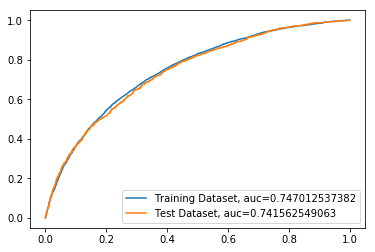

In [44]:
# Plot the ROC of the training set vs. the test set

from sklearn.metrics import roc_curve

# For Training Dataset, plot roc curve
fpr, tpr, thresholds = roc_curve(y_train, clf_final.predict_proba(X_train)[:,1])
auc = roc_auc_score(y_train, clf_final.predict_proba(X_train)[:,1])
plt.plot(fpr,tpr,label="Training Dataset, auc="+str(auc))

# For Test Dataset, plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, clf_final.predict_proba(X_test)[:,1])
auc = roc_auc_score(y_test, clf_final.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label="Test Dataset, auc="+str(auc))


plt.legend(loc=0)

C:\Users\wliu\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


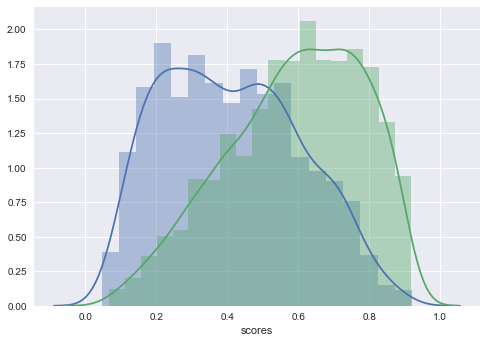

In [45]:
# Return the probablity of "1" class to training set and test set
y_hats_train = clf_final.predict(X_train)
class1_proba_train = clf_final.predict_proba(X_train)[:,1]
class0_proba_train = clf_final.predict_proba(X_train)[:,0]
df_train = pd.DataFrame(X_train, columns = df_X_dummy.columns)
df_train.loc[:,'y_actual'] = y_train
df_train.loc[:,'y_hats'] = y_hats_train
df_train.loc[:,'class1_proba'] = class1_proba_train

y_hats_test = clf_final.predict(X_test)
class1_proba_test = clf_final.predict_proba(X_test)[:,1]
class0_proba_test = clf_final.predict_proba(X_test)[:,0]
df_test = pd.DataFrame(X_test)
df_test.loc[:,'y_actual'] = y_test
df_test.loc[:,'y_hats'] = y_hats_test
df_test.loc[:,'class1_proba'] = class1_proba_test

In [46]:
import seaborn as sns
y_hats_test = clf_final.predict_proba(X_test)
test_eval = pd.DataFrame({'class':y_test, 'scores': list(zip(*y_hats_test))[0]})
class1_scores = test_eval[test_eval['class'] == 1]['scores']
class0_scores = test_eval[test_eval['class'] == 0]['scores']
sns.distplot(class1_scores, label = "class1_scores")
sns.distplot(class0_scores, label = "class0_scores")

array([ 0.71885451,  0.60962581,  0.20659611, ...,  0.84483459,
        0.52552383,  0.52313238])

# Model Calibration

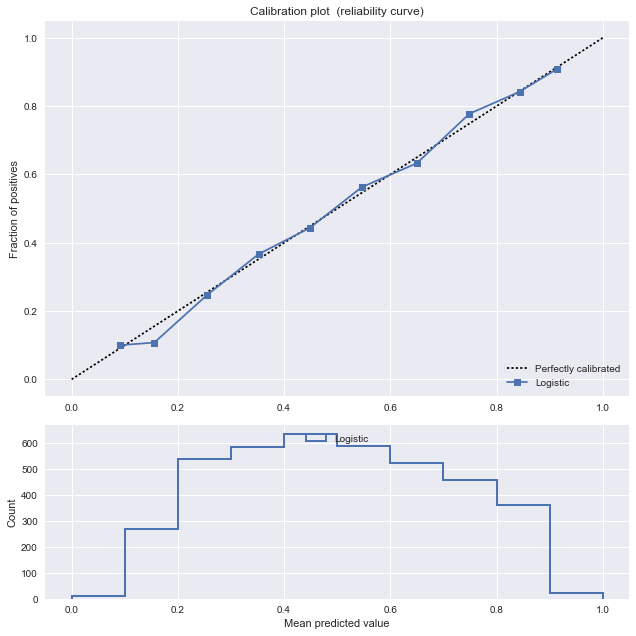

In [50]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

plt.figure(figsize=(9, 9))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic')
                  ]:
    clf.fit(X_test, y_test)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plot  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

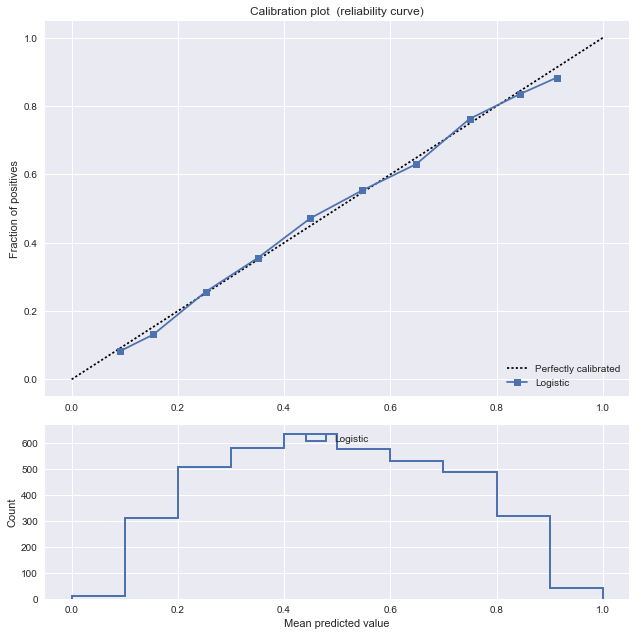

In [51]:
plt.figure(figsize=(9, 9))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic')
                  ]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plot  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()